In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [2]:
# leggo il dataset ed il target

dataset = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned-\dataset-.csv', header = 0)
features_names = list(dataset.columns) # ottengo i nomi delle features
features_names.pop(0) # rimuovo il primo addresses, in quanto non e' una feature
pairs_number_features = list() # creo una lista che contiene coppie <#_feature, nome_feature>
idx = 0

while idx < len(features_names):
    pair = (idx, features_names[idx])
    pairs_number_features.append(pair)
    idx+=1
    
print(pairs_number_features)

target = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned-\target.csv', header = 0)

[(0, 'balance'), (1, 'lifetime'), (2, 'tx_in'), (3, 'investment_to_contract/tx_in'), (4, 'payment_from_contract/tx_out'), (5, '#addresses_paying_contract'), (6, '#addresses_paid_by_contract'), (7, 'mean_v1'), (8, 'sdev_v1'), (9, 'sdev_v2'), (10, 'paid_rate'), (11, 'paid_one'), (12, 'percentage_some_tx_in'), (13, 'sdev_tx_in'), (14, 'percentage_some_tx_out'), (15, 'known_rate'), (16, 'owner_gets_eth_Wo_investing')]


In [3]:
X = dataset.values[:, 1:] # rimuovo la prima colonna che contiene gli indirizzi
y = target.values

# divido in train set (TR) e test set (TS)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) 

from collections import Counter

y_train_list = [item for sublist in y_train.tolist() for item in sublist]
print("Before SMOTE :" , Counter(y_train_list))

Before SMOTE : Counter({0: 3107, 1: 538})


In [4]:
smote = SMOTE(random_state = 21)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE :" , Counter(y_train_smote))

After SMOTE : Counter({0: 3107, 1: 3107})


In [17]:
param_dist_DT = {
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [6, 7, 8],
            'min_samples_split' : [20, 25, 30]
}

In [18]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=param_dist_DT, cv=3, n_jobs=8)

grid_dt.fit(X_train_smote,y_train_smote)
y_pred_train = grid_dt.predict(X_train_smote) # effettuo la predizione su train set
print('best hyperparameters:: ', grid_dt.best_params_) # stampo i migliori iperparametri
print('best score:: ', grid_dt.best_score_) # media degli score (basata sulla metrica di scoring) date sulle cross validation
print('recall score on TR:: ', recall_score(y_train_smote, y_pred_train))
print('precision score on TR:: ', precision_score(y_train_smote, y_pred_train))

best hyperparameters::  {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 20}
best score::  0.8505049506980941
recall score on TR::  0.8667524943675571
precision score on TR::  0.907345013477089


In [19]:
clf_dt = DecisionTreeClassifier(**grid_dt.best_params_)
clf_dt.fit(X_train_smote, y_train_smote)
print('accuracy score on TR:: ', clf_dt.score(X_train_smote, y_train_smote))
print('accuracy score on TS:: ', clf_dt.score(X_test, y_test))

accuracy score on TR::  0.8891213389121339
accuracy score on TS::  0.8377192982456141


In [21]:
param_dist_RF = {
            'n_estimators':[170, 190, 210],
            'criterion':['entropy', 'gini'],
            'max_depth' : [9, 10],
            'max_features' : [5],
            'min_samples_split' : [30, 35],
            'bootstrap': [True, False]
}

In [24]:
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_dist_RF, cv=3, n_jobs=8)

grid_rf.fit(X_train_smote,y_train_smote)
y_pred_train = grid_rf.predict(X_train_smote) # effettuo la predizione su train set
print('best hyperparameters:: ', grid_rf.best_params_) # stampo i migliori iperparametri
print('best score:: ', grid_rf.best_score_) # media degli score (basata sulla metrica di scoring) date sulle cross validation
print('recall score on TR:: ', recall_score(y_train_smote, y_pred_train))
print('precision score on TR:: ', precision_score(y_train_smote, y_pred_train))

best hyperparameters::  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 5, 'min_samples_split': 30, 'n_estimators': 190}
best score::  0.8945975619683972
recall score on TR::  0.9053749597682652
precision score on TR::  0.9445936870382807


In [25]:
clf_rf = RandomForestClassifier(**grid_dt.best_params_)
clf_rf.fit(X_train_smote, y_train_smote)
print('accuracy score on TR:: ', clf_rf.score(X_train_smote, y_train_smote))
print('accuracy score on TS:: ', clf_rf.score(X_test, y_test))

accuracy score on TR::  0.9013517862890248
accuracy score on TS::  0.8585526315789473


In [50]:
grid_param_XGB = {
                'learning_rate' : [0.1],
                'n_estimators' : [240, 250],
                'max_depth': [8, 9, 10],
                'colsample_bytree' : [0.8],
                'subsample' : [0.8],
                'reg_lambda' : [150]
}

In [51]:
grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='aucpr'), param_grid=grid_param_XGB, cv=3, n_jobs=8)

grid_xgb.fit(X_train_smote,y_train_smote)
y_pred_train = grid_xgb.predict(X_train_smote) # effettuo la predizione su train set
print('best hyperparameters:: ', grid_xgb.best_params_) # stampo i migliori iperparametri
print('best score:: ', grid_xgb.best_score_) # media degli score (basata sulla metrica di scoring) date sulle cross validation
print('recall score on TR:: ', recall_score(y_train_smote, y_pred_train))
print('precision score on TR:: ', precision_score(y_train_smote, y_pred_train))

best hyperparameters::  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 250, 'reg_lambda': 150, 'subsample': 0.8}
best score::  0.894275190207107
recall score on TR::  0.9130994528484069
precision score on TR::  0.9516940623951694


In [52]:
clf_xgb = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 8, n_estimators = 250, reg_lambda = 150, 
                            subsample = 0.8, colsample_bytree = 0.8, use_label_encoder = False, eval_metric='aucpr')
clf_xgb.fit(X_train_smote, y_train_smote)
print('accuracy score on TR:: ', clf_xgb.score(X_train_smote, y_train_smote))
print('accuracy score on TS:: ', clf_xgb.score(X_test, y_test))

accuracy score on TR::  0.9333762471837785
accuracy score on TS::  0.8717105263157895


In [33]:
model_params = {
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': { 
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [6, 7, 8],
            'min_samples_split' : [20, 25, 30]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators':[170, 190, 210],
            'criterion':['entropy', 'gini'],
            'max_depth' : [9, 10],
            'max_features' : [5],
            'min_samples_split' : [30, 35],
            'bootstrap': [True, False]
        }
    },
    'xgboost': {
        'model': xgb.XGBClassifier(subsample = 0.8, 
                                   colsample_bytree = 0.8,
                                   eval_metric = 'aucpr', 
                                   use_label_encoder = False),
        'params': {
                'learning_rate' : [0.05, 0.1],
                'n_estimators' : [240, 250, 260],
                'max_depth': [8, 9, 10],
                'colsample_bytree' : [0.8],
                'subsample' : [0.8],
                'reg_lambda' : [150]
        }
    }
}

In [34]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False, n_jobs=8)
    clf.fit(X_train_smote, y_train_smote.ravel())
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_ # necessario per riallenare
    })
    
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,decision_tree,0.850666,"{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 20}"
1,random_forest,0.895885,"{'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'min_samples_split': 30, 'n_estimators': 210}"
2,xgboost,0.895563,"{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 260, 'reg_lambda': 150, 'subsample': 0.8}"


In [35]:
models_list = sorted(scores, key=lambda d: d['best_score']) # ordino in base al best_score
model = models_list[-1] # prendo l'ultimo modello (quello con score piu' alto)
clf = model.get('best_estimator') # ottengo i valori con cui allenare
clf.fit(X_train_smote, y_train_smote) # rialleno

RandomForestClassifier(bootstrap=False, max_depth=10, max_features=5,
                       min_samples_split=30, n_estimators=210)

                    (Number, Feature)  Importance
0                      (11, paid_one)    0.117610
1                    (15, known_rate)    0.113849
2                          (2, tx_in)    0.107013
3    (6, #addresses_paid_by_contract)    0.092020
4   (3, investment_to_contract/tx_in)    0.082350
5                    (13, sdev_tx_in)    0.074405
6                        (7, mean_v1)    0.052150
7         (12, percentage_some_tx_in)    0.051832
8                       (1, lifetime)    0.048200
9                     (10, paid_rate)    0.047767
10                       (0, balance)    0.047470
11                       (9, sdev_v2)    0.044552
12    (5, #addresses_paying_contract)    0.042527
13  (16, owner_gets_eth_Wo_investing)    0.029269
14                       (8, sdev_v1)    0.018189
15       (14, percentage_some_tx_out)    0.017162
16  (4, payment_from_contract/tx_out)    0.013634


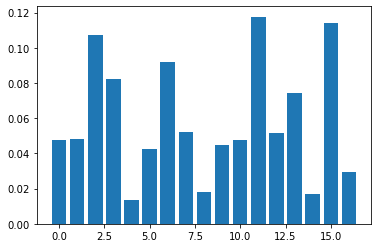

In [36]:
features_importances = clf.feature_importances_
res = dict(zip(pairs_number_features, features_importances))
sorted_dict = dict(sorted(res.items(), key=lambda item: item[1], reverse = True))
print(pd.DataFrame(list(sorted_dict.items()),columns=['(Number, Feature)', 'Importance']))
plt.bar(range(len(features_importances)), features_importances)
plt.show()

precision score::  0.5714285714285714
recall score::  0.6222222222222222
accuracy score::  0.875
F1 score:: 0.5957446808510639


<AxesSubplot:>

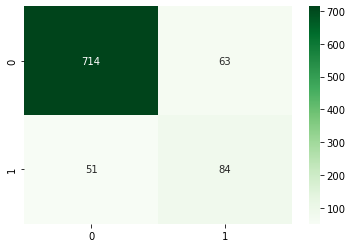

In [37]:
# faccio la predizione e stampo le statistiche sul modello migliore (quello che ha vinto nella GridSearch)

y_pred = clf.predict(X_test)
#print(clf.predict_proba(X_test)) # per vedere le probabilita' con cui sono classificati come ponzi o non ponzi
print('precision score:: ', precision_score(y_test, y_pred)) # TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred))	     # TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred))	 # (TP + TN)/ (TP + FN + TN + FP)
print('F1 score::', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')

precision score::  0.54421768707483
recall score::  0.5925925925925926
accuracy score::  0.8662280701754386
F1 score:: 0.5673758865248226


<AxesSubplot:>

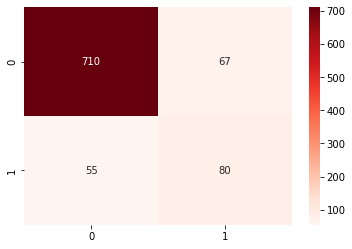

In [38]:
# risultati ottenuti con il secondo migliore

model = models_list[1] # prendo il modello medio
clf2 = model.get('best_estimator') # ottengo i valori con cui allenare
clf2.fit(X_train_smote, y_train_smote.ravel()) # rialleno
y_pred2 = clf2.predict(X_test)
#print(clf2.predict_proba(X_test)) # per vedere le probabilita' con cui sono classificati come ponzi o non ponzi
print('precision score:: ', precision_score(y_test, y_pred2)) #  TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred2))	     # 	TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred2))	 #  (TP + TN)/ (TP + FN + TN + FP)
print('F1 score::', f1_score(y_test, y_pred2))
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')